<a href="https://colab.research.google.com/github/hafizhahnajwa20/SISTEM-REKOMENDASI-ABON-UMI/blob/main/Algoritma_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Collaborative Filtering dan Tren Analisis Penjualan (Prediksi dan Rekomendasi) menggunakan Algoritma LightGBM**

Mounted at /content/drive
✅ Data berhasil dimuat. Kolom: ['Tanggal', 'Nama Abon', 'Jenis Abon', 'Berat Kemasan', 'Jumlah', 'Harga Satuan', 'Total']
      Tanggal  Nama Abon Jenis Abon Berat Kemasan  Jumlah Harga Satuan  \
0  13/01/2025  Abon Ikan      Pedas      100 gram      19  Rp22.000,00   
1  13/01/2025  Abon Ikan      Manis      200 gram       3  Rp38.000,00   
2  13/01/2025  Abon Ayam      Pedas      200 gram       7  Rp43.000,00   
3  13/01/2025  Abon Ayam      Pedas      100 gram       2  Rp27.000,00   
4  13/01/2025  Abon Ikan      Pedas      500 gram       2  Rp80.000,00   

          Total  
0  Rp418.000,00  
1  Rp114.000,00  
2  Rp301.000,00  
3   Rp54.000,00  
4  Rp160.000,00   

Data setelah di-preprocess (diubah menjadi angka):
     Tanggal  Nama Barang Jenis Abon Berat Kemasan  Jumlah Barang  \
0 2025-01-13            1      Pedas      100 gram             19   
1 2025-01-13            1      Manis      200 gram              3   
2 2025-01-13            0      Pedas   

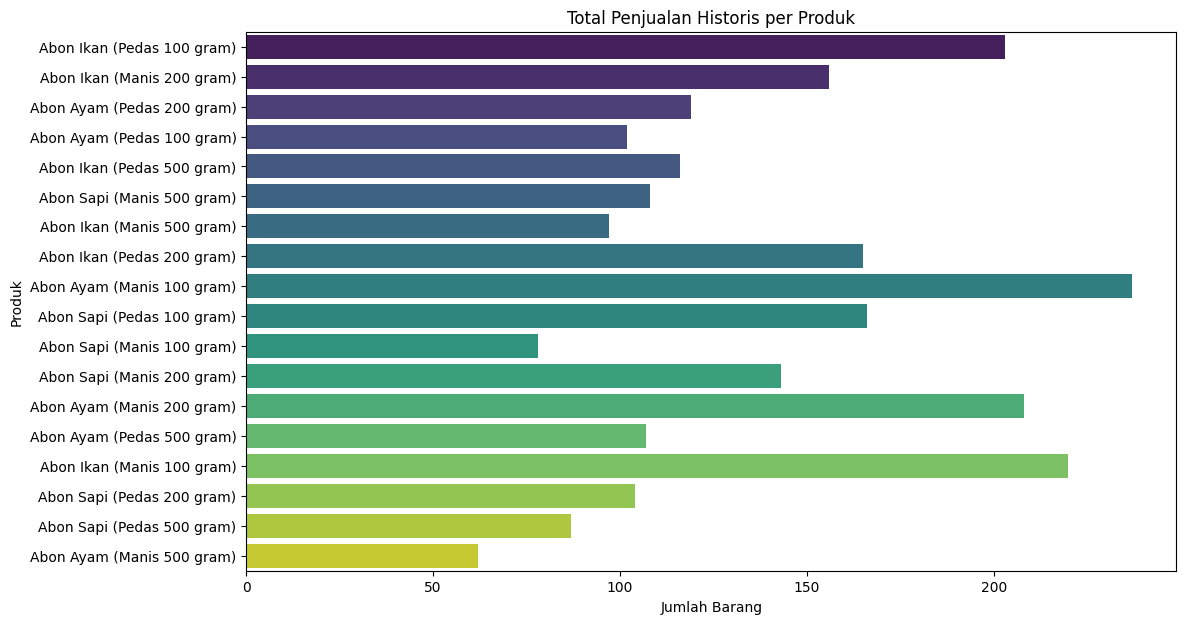



🚀 Memulai pelatihan model LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23
[LightGBM] [Info] Number of data points in the train set: 683, number of used features: 5
[LightGBM] [Info] Start training from score 2.929722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

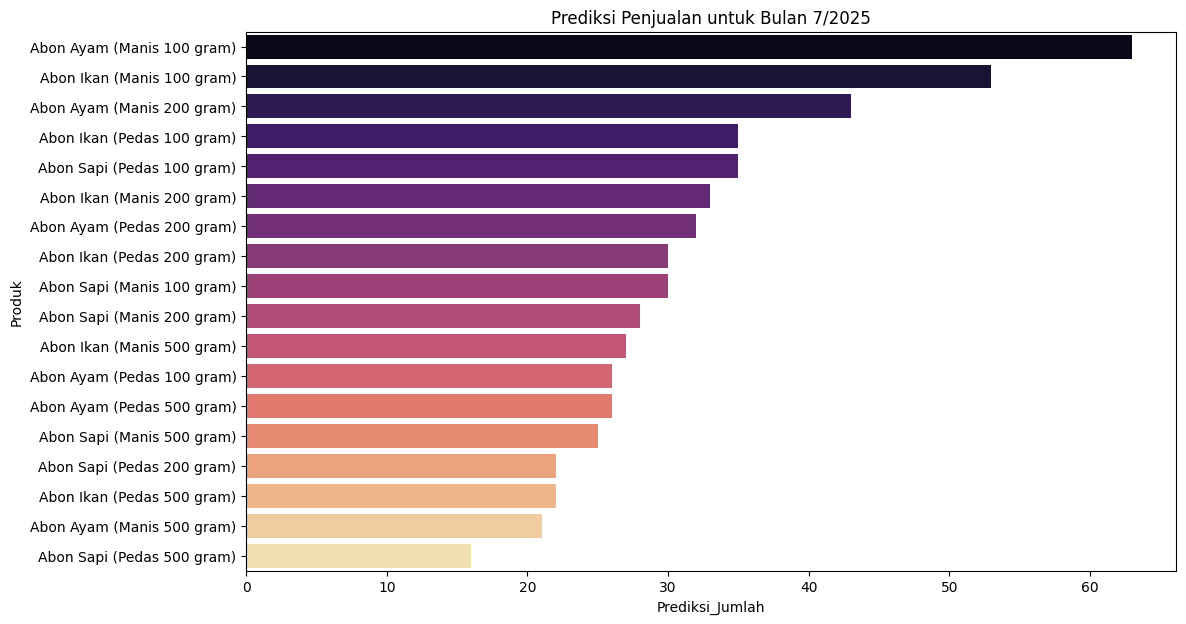

💡 Rekomendasi Utama:
Berdasarkan model prediksi, produk yang berpotensi **paling laku** di Bulan 7/2025 adalah **Abon Ayam** dengan kemasan **Manis 100 gram**.
Toko 'Abon Ummi' disarankan untuk mempersiapkan stok lebih untuk produk tersebut.


In [1]:
# --- 0. Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# Path ke file CSV
file_path = '/content/drive/MyDrive/abon.csv'

# --- 1. Import Library ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# --- 2. Load Data ---
df = pd.read_csv(file_path)
print("✅ Data berhasil dimuat. Kolom:", df.columns.tolist())
print(df.head(), "\n", "="*50, "\n")

# --- 3. Rename & Tambahkan Kolom ---
df.rename(columns={'Nama Abon':'Nama Barang','Jumlah':'Jumlah Barang'}, inplace=True)
df['Kemasan'] = df['Jenis Abon'].astype(str) + ' ' + df['Berat Kemasan'].astype(str)

# Tambahkan kolom Alamat dummy (jika tidak ada di CSV)
if 'Alamat' not in df.columns:
    df['Alamat'] = np.random.choice(['Cappa Galung','Ujung Sabbang','Bacukiki'], len(df))

# Tambahkan kolom Pembeli dummy (jika tidak ada)
df['Pembeli'] = np.random.choice(['Ummi','Rina','Ali','Budi'], len(df))

# Bersihkan harga satuan & hitung total
df['Harga Satuan'] = df['Harga Satuan'].replace('[Rp,.]', '', regex=True).astype(int)
df['Total'] = df['Jumlah Barang'] * df['Harga Satuan']

# Konversi Tanggal
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y', errors='coerce')
df['Bulan'] = df['Tanggal'].dt.month
df['Tahun'] = df['Tanggal'].dt.year

# --- 4. Encoding Kolom Kategorikal ---
encoders = {}
for col in ['Pembeli','Alamat','Nama Barang','Kemasan']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

print("Data setelah di-preprocess (diubah menjadi angka):")
print(df.head(), "\n", "="*50, "\n")

# --- 5. Visualisasi Historis ---
df_viz = df.copy()
for col, le in encoders.items():
    df_viz[col] = le.inverse_transform(df[col])
df_viz['Produk'] = df_viz['Nama Barang'] + ' (' + df_viz['Kemasan'] + ')'

plt.figure(figsize=(12,7))
sns.barplot(data=df_viz, y='Produk', x='Jumlah Barang', estimator=sum, errorbar=None, palette='viridis', hue='Produk', legend=False)
plt.title('Total Penjualan Historis per Produk')
plt.show()
print("\n" + "="*50 + "\n")

# --- 6. Model LightGBM ---
X = df[['Pembeli','Alamat','Nama Barang','Kemasan','Bulan','Tahun']]
y = df['Jumlah Barang']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi dan melatih model LightGBM
model = lgb.LGBMRegressor(objective='regression', n_estimators=100, random_state=42)

print("🚀 Memulai pelatihan model LightGBM...")
model.fit(X_train, y_train)
print("Pelatihan model selesai.")

# Evaluasi model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Evaluasi Model - Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Artinya, rata-rata kesalahan prediksi model adalah sekitar {rmse:.0f} unit barang.\n")
print("="*50, "\n")

# --- 7. Prediksi untuk Juli 2025 ---
future_month, future_year = 7, 2025
future_scenarios = list(itertools.product(df['Pembeli'].unique(), df['Alamat'].unique(), df['Nama Barang'].unique(), df['Kemasan'].unique()))
future_df = pd.DataFrame(future_scenarios, columns=['Pembeli','Alamat','Nama Barang','Kemasan'])
future_df['Bulan'], future_df['Tahun'] = future_month, future_year

# Prediksi
preds = model.predict(future_df)
future_df['Prediksi_Jumlah'] = np.clip(np.round(preds), 0, None)

# Decode kembali label untuk interpretasi
decoded_future = future_df.copy()
for col, le in encoders.items():
    decoded_future[col] = le.inverse_transform(future_df[col])

# Agregasi prediksi
trend = decoded_future.groupby(['Nama Barang','Kemasan'])['Prediksi_Jumlah'].sum().reset_index()
trend_sorted = trend.sort_values(by='Prediksi_Jumlah', ascending=False)

print("✅ HASIL REKOMENDASI & TREN PENJUALAN\n")
print(f"Prediksi Total Penjualan per Produk untuk Bulan {future_month}/{future_year}:")
print(trend_sorted, "\n", "="*50, "\n")

# --- 8. Visualisasi Prediksi ---
trend_sorted['Produk'] = trend_sorted['Nama Barang'] + ' (' + trend_sorted['Kemasan'] + ')'
plt.figure(figsize=(12,7))
sns.barplot(data=trend_sorted, y='Produk', x='Prediksi_Jumlah', palette='magma', hue='Produk', legend=False)
plt.title(f'Prediksi Penjualan untuk Bulan {future_month}/{future_year}')
plt.show()

# --- 9. Rekomendasi Produk ---
top = trend_sorted.iloc[0]
print("💡 Rekomendasi Utama:")
print(f"Berdasarkan model prediksi, produk yang berpotensi **paling laku** di Bulan {future_month}/{future_year} adalah **{top['Nama Barang']}** dengan kemasan **{top['Kemasan']}**.")
print("Toko 'Abon Ummi' disarankan untuk mempersiapkan stok lebih untuk produk tersebut.")
